In [1]:
!pip install medmnist

In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset with size 28x28

In [2]:
data_flag = 'dermamnist'
# data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [8]:
info['python_class']

'DermaMNIST'

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [3]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\Cobra\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\Cobra\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\Cobra\.medmnist\dermamnist.npz


In [4]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints: 7007
    Root location: C:\Users\Cobra\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0
Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapo

In [5]:
# visualization

train_dataset.montage(length=1)

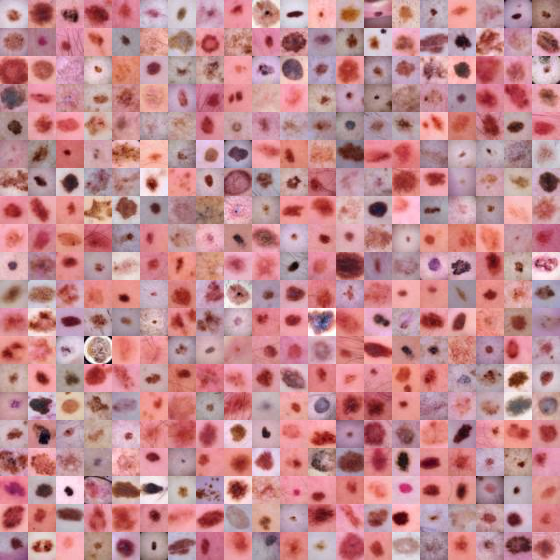

In [6]:
# montage

train_dataset.montage(length=20)

In [7]:
import numpy as np
from PIL import Image

def combine_images_per_label(dataset, num_images=5):
    labels = np.unique([y for _, y in dataset])  # 獲取所有標籤
    images_per_label = []

    for label in labels:
        count = 0
        images = []
        for i in range(len(dataset)):
            x, y = dataset[i]
            if y == label and count < num_images:  # 直接比較 y
                img = x.permute(1, 2, 0).numpy()  # 將通道移到最後並轉換為 numpy 陣列
     
                # 檢查圖像範圍，避免過度增強顏色
                if np.max(img) <= 1.0:
                    img = np.clip(img * 255, 0, 255).astype(np.uint8)  # 正確處理範圍
                else:
                    img = img.astype(np.uint8)  # 如果圖像已經在 [0, 255]，直接轉換
                    
                images.append(Image.fromarray(img))  # 將圖像轉換為 PIL 格式
                count += 1
            if count >= num_images:
                break
        images_per_label.append(images)

    # 計算合併圖像的大小
    img_width, img_height = images_per_label[0][0].size
    total_width = img_width * len(labels)
    total_height = img_height * num_images

    # 創建一個新的空白圖像
    combined_image = Image.new('RGB', (total_width, total_height))

    # 將每個標籤的圖像放置到合併圖像中
    for label_index, images in enumerate(images_per_label):
        for img_index, img in enumerate(images):
            combined_image.paste(img, (label_index * img_width, img_index * img_height))

    combined_image.show()  # 顯示合併後的圖像
    combined_image.save("combined_images.png")  # 保存合併後的圖像

combine_images_per_label(train_dataset)


## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [12]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [13]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 704/704 [00:53<00:00, 13.09it/s]


In [14]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.990  acc:0.851
test  auc: 0.969  acc:0.757


# We then check a 2D dataset with size 224x224

In [15]:
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=224, mmap_mode='r')

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: /home/sr/.medmnist/pathmnist_224.npz


In [16]:
x, y = train_dataset[0]

print(x.shape, y.shape)

torch.Size([3, 224, 224]) (1,)


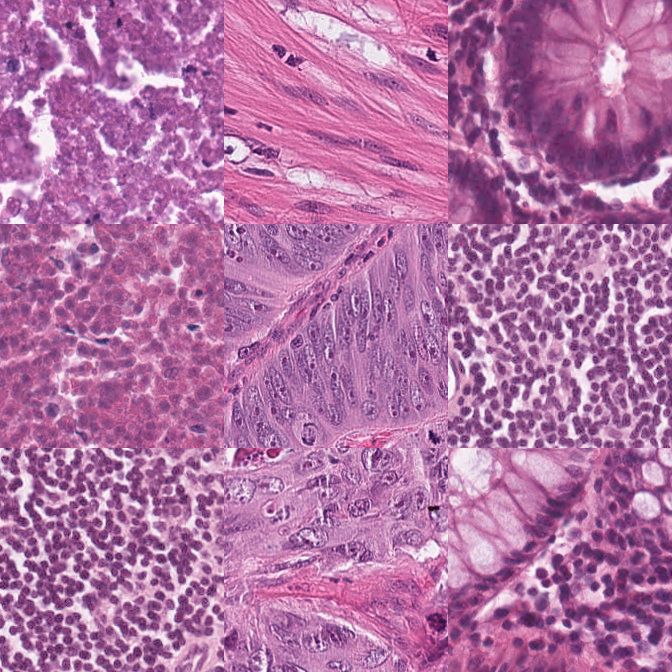

In [20]:
train_dataset.montage(length=3)

## Then we train and evaluate on this 224x224 dataset

In [21]:
from torchvision.models import resnet18

model = resnet18(num_classes=n_classes).cuda()

criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [22]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs.cuda())
        targets = targets.cuda()
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 704/704 [02:39<00:00,  4.41it/s]


In [23]:
split = 'test'

model.eval()
y_true = torch.tensor([])
y_score = torch.tensor([])

data_loader = train_loader_at_eval if split == 'train' else test_loader

with torch.no_grad():
    for inputs, targets in data_loader:
        inputs = inputs.cuda()
        outputs = model(inputs)
        outputs = outputs.softmax(dim=-1)
        y_score = torch.cat((y_score, outputs.cpu()), 0)

    y_score = y_score.detach().numpy()
    
    evaluator = Evaluator(data_flag, split, size=224)
    metrics = evaluator.evaluate(y_score)

    print('%s  auc: %.3f  acc: %.3f' % (split, *metrics))

test  auc: 0.760  acc: 0.277


# We then check a 3D dataset with size 28x28x28

In [24]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: /home/sr/.medmnist/organmnist3d.npz


In [25]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 28, 28, 28) (1,)


In [26]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])


In [27]:
frames = train_dataset.montage(length=1, save_folder="tmp/")
frames[10]

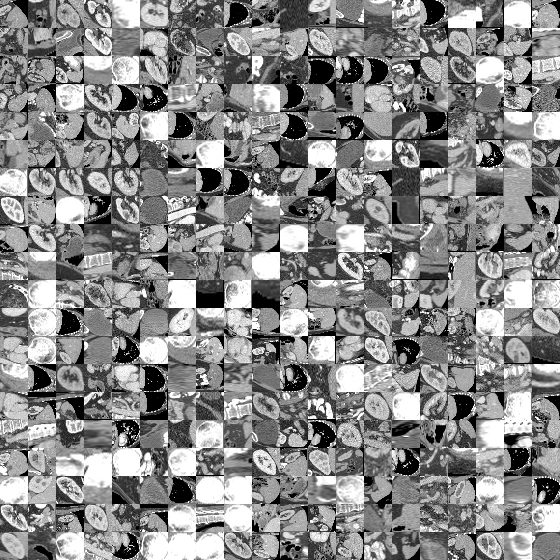

In [28]:
frames = train_dataset.montage(length=20, save_folder="tmp/")

frames[10]

## Go and check the generated [gif](tmp/organmnist3d_train_montage.gif) ;)

# We then check a 3D dataset with size 64x64x64

In [29]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: /home/sr/.medmnist/organmnist3d_64.npz


In [30]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 64, 64, 64) (1,)


In [31]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 64, 64, 64]) torch.Size([128, 1])


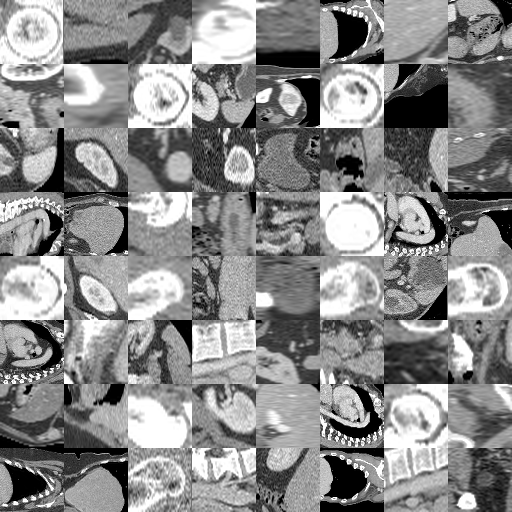

In [32]:
frames = train_dataset.montage(length=8, save_folder="tmp/")

frames[10]

## Go and check the generated [gif](tmp/organmnist3d_64_train_montage.gif) ;)

# Check [EXTERNAL] [`MedMNIST/experiments`](https://github.com/MedMNIST/experiments)

Training and evaluation scripts to reproduce both 2D and 3D experiments in our paper, including PyTorch, auto-sklearn, AutoKeras and Google AutoML Vision together with their weights ;)